In [1]:
# PCA AND LDA SCRIPT
require(compiler)
require(RSpectra)
require(MASS)
require(nnet)
setMKLthreads(16)
#setwd('ag1000g_phase2/learning')

Loading required package: compiler
Loading required package: RSpectra
Loading required package: MASS
Loading required package: nnet


In [2]:
load('Haplotype_16Filtered.RData')
ls()
# HAPLOTYPE ALREADY MAF FILTERED AND LD PRUNNED

[1] "haplotype" "label"     "POS"

In [3]:
# GET GENOTYPE, ITS LABEL, AND COLOUR CODE
odd<-seq(1, nrow(haplotype), 2)
even<-seq(2, nrow(haplotype), 2)
mode(haplotype)<-'numeric'
genotype<-haplotype[odd,]+haplotype[even,]
genotype_label<-label[odd]
genotype_col<-colors()[as.numeric(factor(genotype_label))*4]
dim(genotype)
length(genotype_label)
rm(odd); rm(even);

[1]   1142 117461

[1] 1142

In [4]:
# REMOVE POPULATIONS GQgam, GHgam, GNcol BECAUSE OF SMALL SAMPLE SIZE
s<-!(genotype_label %in% c('GQgam', 'GHgam', 'GNcol'))
genotype<-genotype[s,]
genotype_label<-genotype_label[s]
genotype_col<-genotype_col[s]
dim(genotype)
length(genotype_label)
length(genotype_col)
rm(s);

[1]   1117 117461

[1] 1117

[1] 1117

In [5]:
# PATTERSON ET AL. (2006) NORMALISATION. 
allele_freq<-apply(genotype, 2, .Primitive('sum'))/(2*nrow(genotype))
min(allele_freq); max(allele_freq);
allele_freq<-matrix(allele_freq, nc=ncol(genotype), nr=nrow(genotype), byrow=T)
normal_genotype<-(genotype-2*allele_freq)/sqrt(allele_freq*(1-allele_freq))
system.time(x<-normal_genotype%*%t(normal_genotype))
# I DON'T KNOW IF THIS STEP IS NECESSARY, NOR DO I KNOW WHAT THE DENOMINATOR SHOULD BE. 
# x IS SOME KIND OF COVARIANCE MATRIX?
x<-x/nrow(normal_genotype)
dim(x)
rm(allele_freq); invisible(gc());

[1] 0.04565801

[1] 0.9512086

   user  system elapsed 
  16.22    0.08    5.28 

[1] 1117 1117

   user  system elapsed 
   5.05    0.00    0.36 

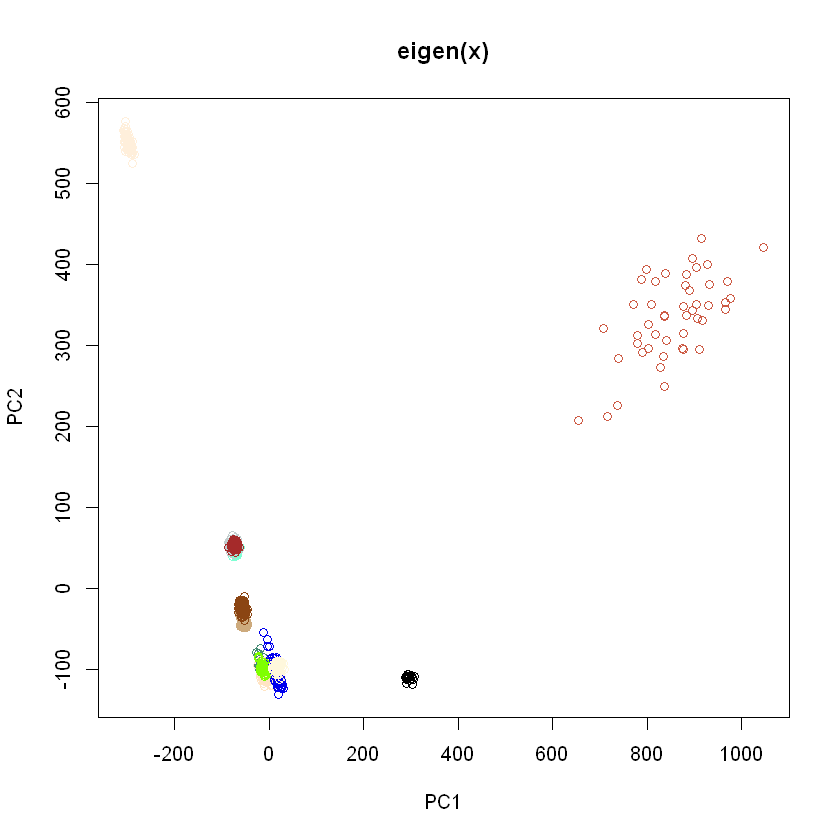

In [6]:
# I'M GOING TO TRY FOUR DIFFERENT WAYS TO RUN PCA. 
# PCA 1. USING eigen() ON x (COV) MATRIX
system.time(e<-eigen(x))
PC1<-x%*%e$vector[,1]
PC2<-x%*%e$vector[,2]
plot(PC1, PC2, col=genotype_col, main='eigen(x)')

   user  system elapsed 
 110.30    2.06   18.96 

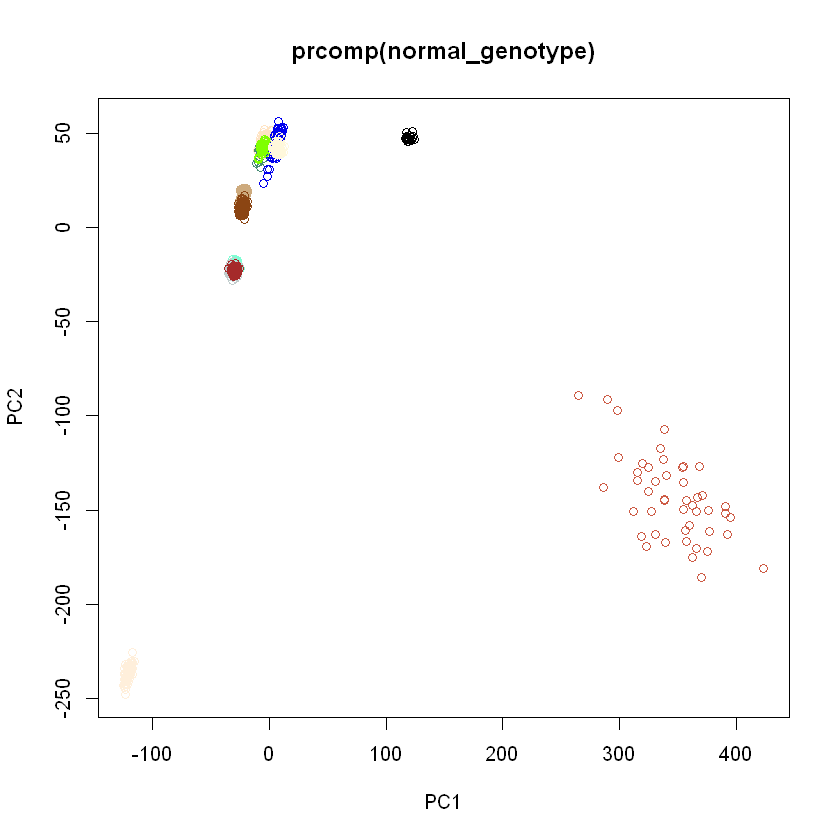

In [7]:
# PCA 2. USING prcomp ON THE DATA MATRIX
system.time(e<-prcomp(normal_genotype))
PC1<-e$x[,1]
PC2<-e$x[,2]
# OR USE THE FIRST TWO COLUMNS OF normal_genotype%*%e$rotation
plot(PC1, PC2, col=genotype_col, main='prcomp(normal_genotype)')

   user  system elapsed 
   5.03    0.00    0.34 

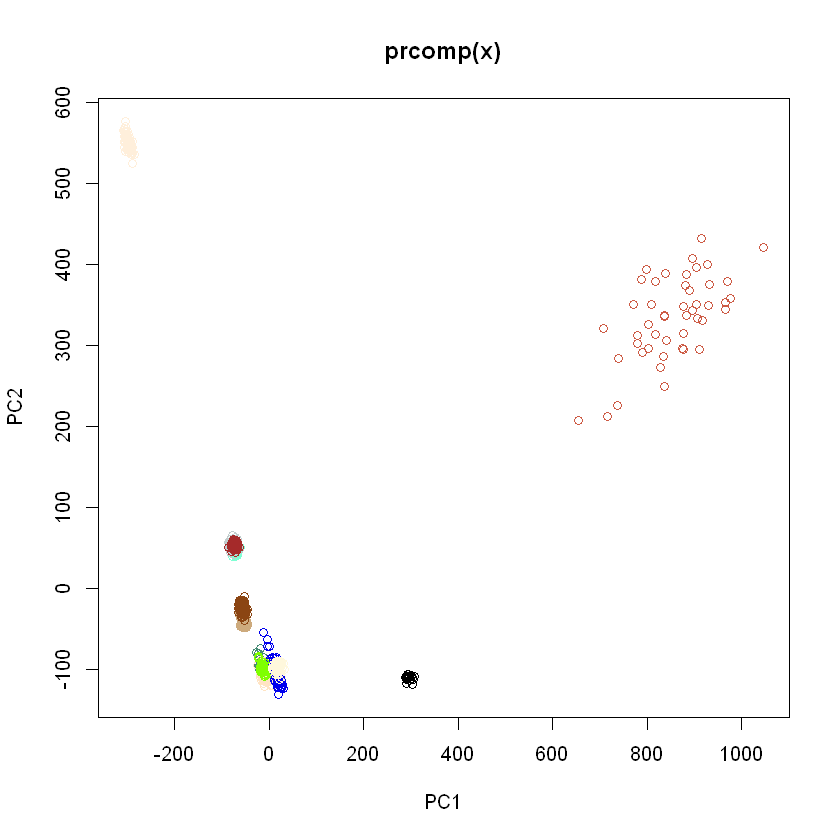

In [8]:
# PCA 3. USING prcomp() ON x
system.time(e<-prcomp(x))
PC1<-e$x[,1]
PC2<-e$x[,2]
plot(PC1, PC2, col=genotype_col, main='prcomp(x)')

   user  system elapsed 
  37.99    5.29    3.44 

   user  system elapsed 
  45.00    3.78   34.96 

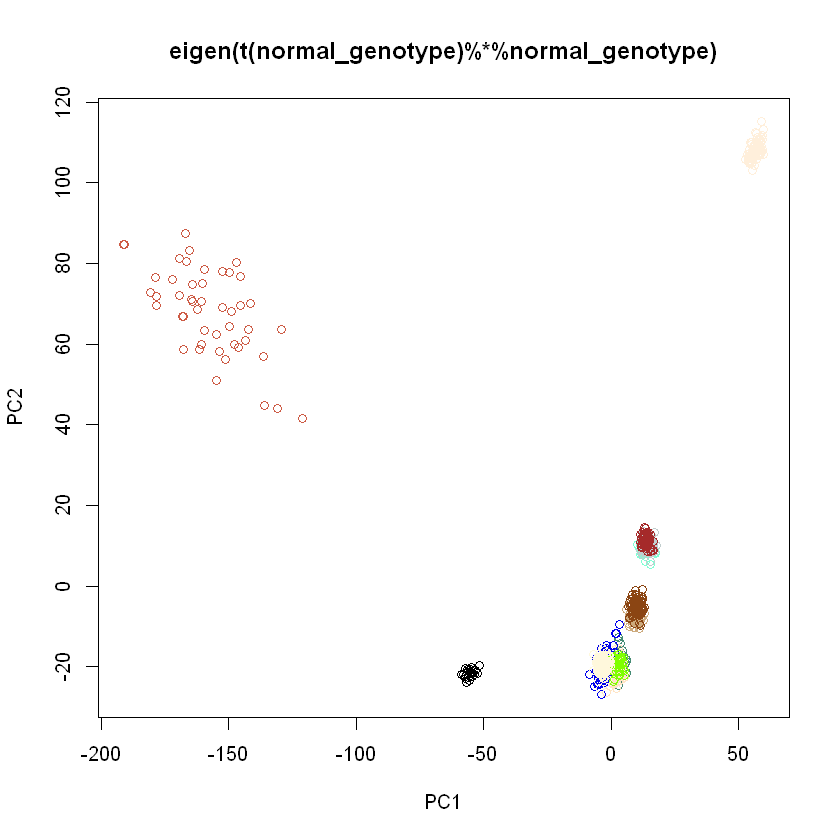

In [9]:
# PCA 4. eigen() ON THE BIG LOCI*LOCI MATRIX. PERFORM ONLY DO ON A SUBSET OF 25,000 SNPS
# eigs() IS A FASTER VERSION OF eigen() IF YOU DON'T NEED ALL EIGENVALUES AND VECTORS
s<-sample(1:ncol(normal_genotype), size=25000)
s<-sort(s)
system.time(x<-t(normal_genotype[,s])%*%normal_genotype[,s])
system.time(e<-eigs(x, 4))
PC1<-normal_genotype[,s]%*%e$vector[,1]
PC2<-normal_genotype[,s]%*%e$vector[,2]
plot(PC1, PC2, col=genotype_col, main='eigen(t(normal_genotype)%*%normal_genotype)')

In [10]:
# SO ALL PCA PROCEDURES ARE EQUIVALENT. THERE ARE SOME SCALING ISSUES BUT DO NOT AFFECT THE OVERSALL SHAPE. 
rm(x); rm(s); invisible(gc())

In [7]:
#################################################
# NOW TURN TO SUPERVISED LEARNING
#################################################
# SPLIT THE DATA INTO TRAINING AND TESTING SET. 75:25, STRATEFIED
train_genotype<-NULL
train_label<-NULL
train_col<-NULL
test_genotype<-NULL
test_label<-NULL
test_col<-NULL

set.seed(12345)
pop<-unique(genotype_label)
for (i in 1:length(pop))
{
	temp<-genotype[genotype_label==pop[i],]
	temp1<-genotype_label[genotype_label==pop[i]]
	temp2<-genotype_col[genotype_label==pop[i]]
    print(paste(pop[i], nrow(temp)))
	s<-sample(nrow(temp), size=round(0.75*nrow(temp)))
	train_genotype<-rbind(train_genotype, temp[s,])
	train_label<-c(train_label, temp1[s])
	train_col<-c(train_col, temp2[s])
	test_genotype<-rbind(test_genotype, temp[-s,])
	test_label<-c(test_label, temp1[-s])
	test_col<-c(test_col, temp2[-s])
}
rm(temp); rm(temp1); rm(temp2); rm(s); invisible(gc()); 

[1] "BFcol 75"
[1] "BFgam 92"
[1] "AOcol 78"
[1] "CIcol 71"
[1] "CMgam 297"
[1] "FRgam 24"
[1] "GAgam 69"
[1] "GHcol 55"
[1] "GM 65"
[1] "GNgam 40"
[1] "GW 91"
[1] "KE 48"
[1] "UGgam 112"


In [8]:
# CHECK DIMENSIONS. THE TRAINING SET HAS 837 INDIVIDUALS. 
dim(train_genotype); length(train_label); length(train_col); 
dim(test_genotype); length(test_label); length(test_col);

[1]    837 117461

[1] 837

[1] 837

[1]    280 117461

[1] 280

[1] 280

In [9]:
# REPEAT PATTERSON'S NORMALISATION BUT ONLY ON THE TRAINING SET
allele_freq<-apply(train_genotype, 2, .Primitive('sum'))/(2*nrow(train_genotype))
allele_freq2<-matrix(allele_freq, nc=ncol(train_genotype), nr=nrow(train_genotype), byrow=T)
normal_train_genotype<-(train_genotype-2*allele_freq2)/sqrt(allele_freq2*(1-allele_freq2))
rm(allele_freq2); invisible(gc()); 

In [10]:
# I DON'T WANT TO PUT 837 INDIVIDUALS AND 117461 LOCI TO TRAIN A CLASSIFIER. 
# I'D LIKE TO REDUCE THE DIMENSION OF THE DATA VIA PCA (ON THE TRAINING SET). 
# USE FIRST n COMPONENTS AS FEATURES (EXPLANATORY VARIABLES). n=50, SAY. 
system.time(e<-prcomp(normal_train_genotype))
n<-50
train_feature<-normal_train_genotype%*%e$rotation[,1:n]
# THESE FEATURES HAVE MEAN ABOUT ZERO
#apply(train_feature, 2, mean)
dim(train_feature)

   user  system elapsed 
  70.05    1.45   11.58 

[1] 837  50

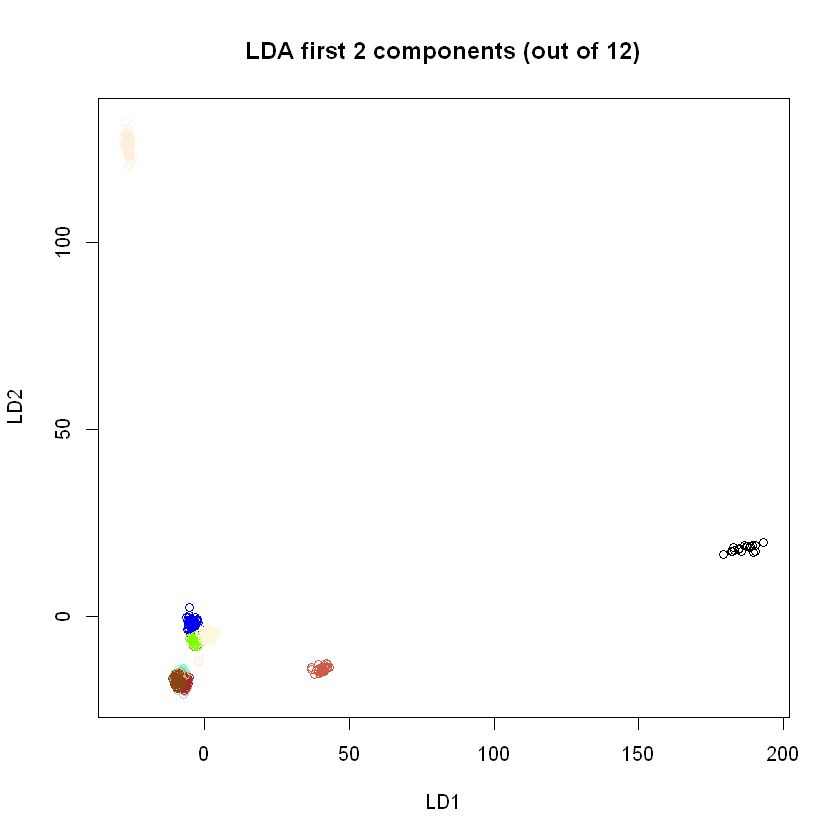

In [11]:
# LINEAR DISCRIMINANT ANALYSIS (LDA) USING train_feature AND A UNIFORM PRIOR
# THERE WILL BE 12 LD COMPONENTS AS THERE ARE 13 CLASSES (POPULATIONS)
m_lda<-lda(train_feature, grouping=train_label, prior=rep(1/length(pop), length(pop)))
LD1_train<-train_feature%*%m_lda$scaling[,1]
LD2_train<-train_feature%*%m_lda$scaling[,2]
LD3_train<-train_feature%*%m_lda$scaling[,3]
LD4_train<-train_feature%*%m_lda$scaling[,4]
LD5_train<-train_feature%*%m_lda$scaling[,5]
LD6_train<-train_feature%*%m_lda$scaling[,6]
LD7_train<-train_feature%*%m_lda$scaling[,7]
LD8_train<-train_feature%*%m_lda$scaling[,8]
plot(LD1_train, LD2_train, col=train_col, 
	xlab='LD1', ylab='LD2', main='LDA first 2 components (out of 12)')


In [12]:
# JUST DISPLAY THE ENTIRE MODEL. TOO MUCH INFORMATION I GUESS!
m_lda

Call:
lda(train_feature, grouping = train_label, prior = rep(1/length(pop), 
    length(pop)))

Prior probabilities of groups:
     AOcol      BFcol      BFgam      CIcol      CMgam      FRgam      GAgam 
0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 
     GHcol         GM      GNgam         GW         KE      UGgam 
0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 

Group means:
              PC1       PC2        PC3       PC4          PC5         PC6
AOcol -127.616891 234.22543   91.80308 -10.04141   13.2490949  -12.017912
BFcol  -31.665709  19.93337  -78.85364  32.51937  -18.7813848   40.773017
BFgam   -3.811088 -42.48525   20.64993 -28.40785   34.2473997   10.135660
CIcol  -33.579103  22.05152 -102.34636  44.60508  -28.8857959   61.432884
CMgam   -1.716333 -44.50229   26.48414 -29.91705   30.5126883    8.947737
FRgam  124.923407 -41.47251  200.45042 346.43136   14.5282284   -0.203673
GAgam    8.664319 -46.33531   87.34480 -43.48352 -1

In [13]:
# NOW TURN TO THE TEST SET. FIRST NORMALISE IT VIA THE SAME PATTERSON FORMULA AND allele_freq
# THEN CREATE test_feature USING THE SAME PCA ROTATION
allele_freq2<-matrix(allele_freq, nc=ncol(test_genotype), nr=nrow(test_genotype), byrow=T)
normal_test_genotype<-(test_genotype-2*allele_freq2)/sqrt(allele_freq2*(1-allele_freq2))
test_feature<-normal_test_genotype%*%e$rotation[,1:n]
dim(test_feature)
rm(allele_freq); rm(allele_freq2); invisible(gc());

[1] 280  50

In [14]:
# PREDICT THE CLASSES GIVEN THE TESTING FEATURES VIA THE EXISTING LDA MODEL. 
result_lda<-predict(m_lda, test_feature)$class
result_lda<-as.character(result_lda)
# ACCURACY. SHOULD BE AROUND 88.9%
sum(result_lda==test_label)/length(test_label)

[1] 0.8892857

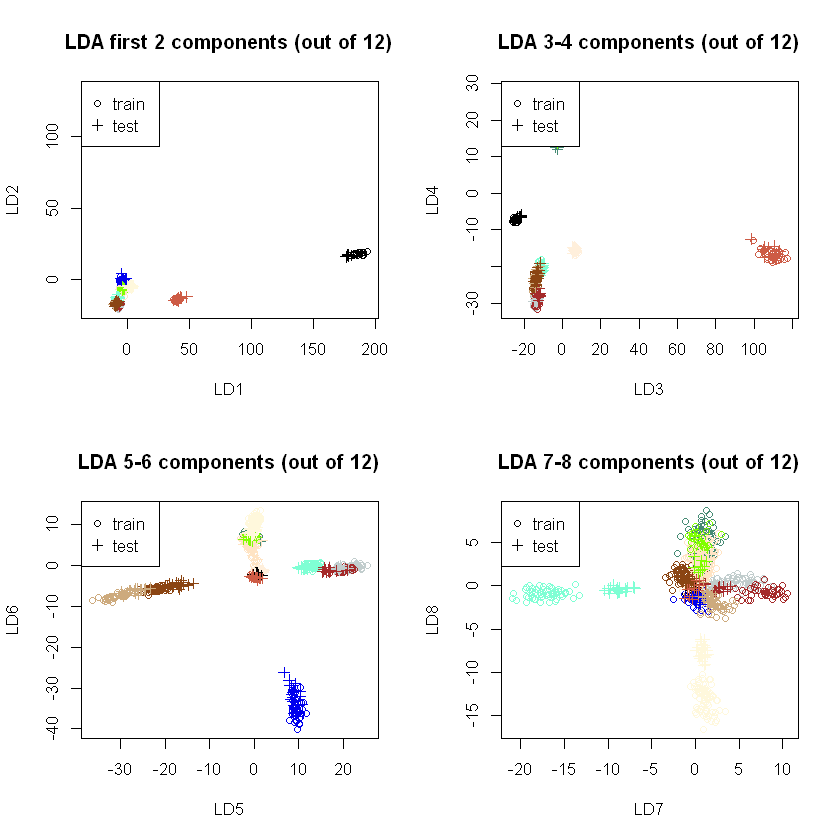

In [15]:
# PLOT THE LD COMPONENTS
LD1_test<-test_feature%*%m_lda$scaling[,1]
LD2_test<-test_feature%*%m_lda$scaling[,2]
LD3_test<-test_feature%*%m_lda$scaling[,3]
LD4_test<-test_feature%*%m_lda$scaling[,4]
LD5_test<-test_feature%*%m_lda$scaling[,5]
LD6_test<-test_feature%*%m_lda$scaling[,6]
LD7_test<-test_feature%*%m_lda$scaling[,7]
LD8_test<-test_feature%*%m_lda$scaling[,8]
# PLOTS
par(mfrow=c(2,2))
plot(LD1_train, LD2_train, col=train_col, 
	xlab='LD1', ylab='LD2', main='LDA first 2 components (out of 12)')
points(LD1_test, LD2_test, col=test_col, pch=3)
legend('topleft', legend=c('train', 'test'), pch=c(1,3))
plot(LD3_train, LD4_train, col=train_col, 
	xlab='LD3', ylab='LD4', main='LDA 3-4 components (out of 12)')
points(LD3_test, LD4_test, col=test_col, pch=3)
legend('topleft', legend=c('train', 'test'), pch=c(1,3))
plot(LD5_train, LD6_train, col=train_col, 
	xlab='LD5', ylab='LD6', main='LDA 5-6 components (out of 12)')
points(LD5_test, LD6_test, col=test_col, pch=3)
legend('topleft', legend=c('train', 'test'), pch=c(1,3))
plot(LD7_train, LD8_train, col=train_col, 
	xlab='LD7', ylab='LD8', main='LDA 7-8 components (out of 12)')
points(LD7_test, LD8_test, col=test_col, pch=3)
legend('topleft', legend=c('train', 'test'), pch=c(1,3))

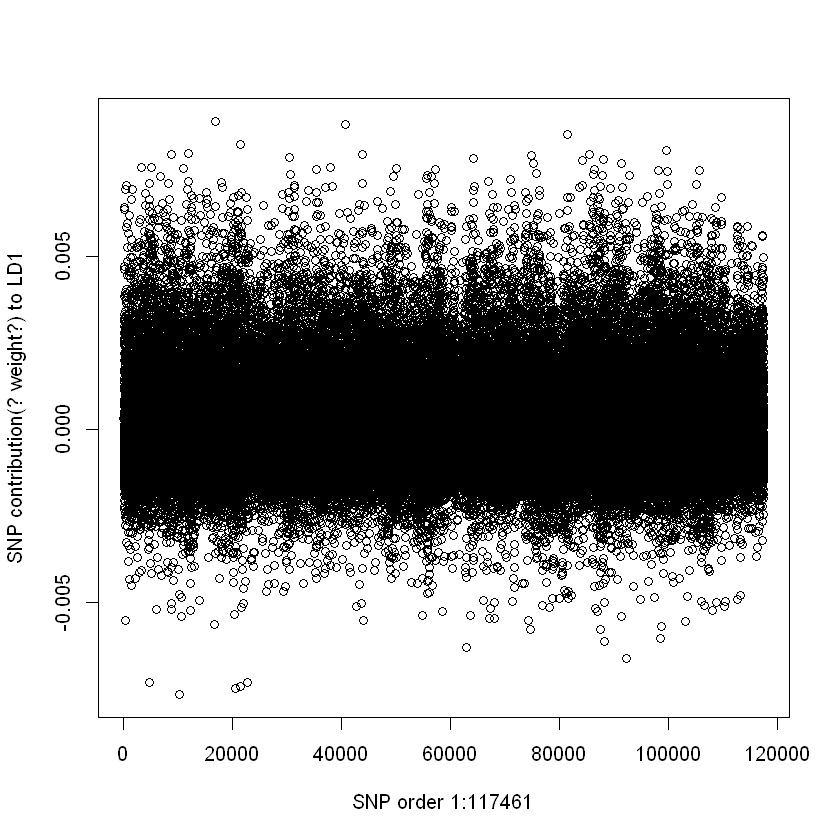

In [16]:
# WHICH LOCI CONTRIBUTE MOST TO THE DISCRIMINANT ANALYSIS?
# LD1 IS A LINEAR COMBINATION OF PC1-PC50, AND PC1-PC50 ARE LINEAR COMBINATIONS OF SNPS
# NOTE THAT LDA1_train<-train_feature%*%m_lda$scaling[,1]
# AND THAT train_feature<-train_normal_genotype%*%e$rotation[,1:n]
# THEN I GUESS WE CAN PICK (BY EYEBALL OR OTHERWISE) THE SNPS WITH THE MOST EXTREME WEIGHTS
plot(e$rotation[,1:n]%*%m_lda$scaling[,1], ylab='SNP contribution(? weight?) to LD1', xlab='SNP order 1:117461')

In [17]:
# HOW ABOUT USING LOGISTIC REGRESSION AS OUR CLASSIFIER? USE muiltinom() FROM PACKAGE nnet. 
# BUT WE NEED TO PUT train_label AND train_feature INTO A DATA FRAME. STUBBORN. 
# AND, NOT SURE IF I UNDERSTAND THE OUTPUTS FROM multinom(). 
train_df<-data.frame(train_label=train_label, train_feature=train_feature)
m_lr<-multinom(train_label~., data=train_df)

# weights:  676 (612 variable)
initial  value 2146.862612 
iter  10 value 60.371696
iter  20 value 50.931941
iter  30 value 48.163214
iter  40 value 46.395027
iter  50 value 44.725102
iter  60 value 42.235899
iter  70 value 38.638564
iter  80 value 35.005933
iter  90 value 33.660933
iter 100 value 31.657616
final  value 31.657616 
stopped after 100 iterations


In [18]:
# SHOWING THE NAMES OF THE ESTIMATED COEFFICIENTS. THE INTERCEPT IS THERE, ALONGSIDE PC1-PC50 FEATURES. 
m_lr$coefnames

[1] "(Intercept)"        "train_feature.PC1"  "train_feature.PC2" 
 [4] "train_feature.PC3"  "train_feature.PC4"  "train_feature.PC5" 
 [7] "train_feature.PC6"  "train_feature.PC7"  "train_feature.PC8" 
[10] "train_feature.PC9"  "train_feature.PC10" "train_feature.PC11"
[13] "train_feature.PC12" "train_feature.PC13" "train_feature.PC14"
[16] "train_feature.PC15" "train_feature.PC16" "train_feature.PC17"
[19] "train_feature.PC18" "train_feature.PC19" "train_feature.PC20"
[22] "train_feature.PC21" "train_feature.PC22" "train_feature.PC23"
[25] "train_feature.PC24" "train_feature.PC25" "train_feature.PC26"
[28] "train_feature.PC27" "train_feature.PC28" "train_feature.PC29"
[31] "train_feature.PC30" "train_feature.PC31" "train_feature.PC32"
[34] "train_feature.PC33" "train_feature.PC34" "train_feature.PC35"
[37] "train_feature.PC36" "train_feature.PC37" "train_feature.PC38"
[40] "train_feature.PC39" "train_feature.PC40" "train_feature.PC41"
[43] "train_feature.PC42" "train_feature.PC43" "train_feature.PC44"
[46] "train_feature.PC45" "train_feature.PC46" "train_feature.PC47"
[49] "train_feature.PC48" "train_feature.PC49" "train_feature.PC50"

In [19]:
# AGAIN JUST DISPLAY THE ENTIRE MODEL. AGAIN THE INTERCEPT IS THERE. 
# WHAT DOES THE INTERCEPTS DO IN THIS MODEL? SOME KIND OF PRIOR?
m_lr

Call:
multinom(formula = train_label ~ ., data = train_df)

Coefficients:
      (Intercept) train_feature.PC1 train_feature.PC2 train_feature.PC3
BFcol  0.02564619       0.013365544      -0.004961362      -0.006347775
BFgam  0.02839710       0.065393333      -0.041532164       0.004586626
CIcol  0.02600098       0.030997311       0.001722673      -0.021311238
CMgam -0.06689409       0.015086074      -0.171869733       0.108322527
FRgam  0.03701182       0.042621359      -0.020560116       0.047043832
GAgam  0.02692189      -0.008139001      -0.057099132       0.063414562
GHcol  0.02314853      -0.041403835      -0.025110717      -0.055440357
GM     0.03539442       0.034507177      -0.029600746       0.013117083
GNgam -0.25872891      -0.050485969      -0.025115974      -0.171084656
GW     0.03541282       0.009603777      -0.032363197      -0.033297820
KE     0.03639147       0.053846754       0.011059045      -0.059217945
UGgam  0.01359959       0.022842888      -0.080488321       0.

In [20]:
# PREDICT WITH OUT TEST SET. AGAIN I NEED TO CREATE A DATA FRAME. 
test_df<-data.frame(test_feature=test_feature)
# TO AVOID ERRORS I NEED TO SET THE COLUMN NAMES OF test_df TO MATCH THOSE OF train_df. VERY STUBBORN. 
names(test_df)<-names(train_df)[-1]
# PUT THE test_df TO TEST THE ALGORITHM
result_lr<-predict(m_lr, test_df, type='class')
result_lr<-as.character(result_lr)
# ACCURACY. SHOULD BE AROUND 90%
sum(result_lr==test_label)/length(test_label)

[1] 0.9